
<img src="https://learn.wqu.edu/assets/39cecb6f6bdccec67223.svg" alt="Unimarconi logo" width="180"/>


---
### **COURSE OF STUDY: Masters of Science Degree in Financial Engineering**

**GROUP CAPSTONE PROJECT**

**Students Name:**  OKON PRINCE, FRACKSON MAKWANGWALA, PAIDAMOYO MUTEPFA

**Group ID:**  22170854

**PROJECT:** Machine Learning-Based Swing Trading Strategy for Cryptocurrencies

**Emails:** okonp07@gmail.com, samutepfa1@yahoo.com, fracksonmakwangwala@gmail.com

---

In [1]:
!pip install ta
!pip install pytrends
!pip install backtrader
!pip install scikeras


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=5cfa26b090c650250e83f0489019c91be7785f39268d85aca4f6b48a3086511d
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 5.5 MB/s eta 0:00:00


In [2]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np
import yfinance as yf

# Technical Indicators
import ta

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor

# Additional Libraries
import datetime

## Data Collection and Preprocessing
In this section, we collect historical price dat using Yahoo Finance API. We also collect macroeconomic data like the US Interest Rates from the FRED database. The collected data is then cleaned and merged for further analysis.



##BTC and Technical Analysis Data

In [19]:
# Import libraries
import yfinance as yf
import ta
import pandas as pd

# Step 1: Fetch historical data for BTC-USD
ticker = 'BTC-USD'
start_date = '2013-01-01'
end_date = '2024-10-12'
data = yf.download(ticker, start=start_date, end=end_date)

# Ensuring that 'Close' is a 1-dimensional Series
close_prices = data['Close'].squeeze()

# Step 2: Calculate technical indicators using the ta library

# 1. Relative Strength Index (RSI)
rsi_indicator = ta.momentum.RSIIndicator(close=close_prices, window=14)
data['RSI'] = rsi_indicator.rsi()

# 2. Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(close=close_prices)
data['MACD'] = macd.macd()
data['MACD_Signal'] = macd.macd_signal()
data['MACD_Hist'] = macd.macd_diff()

# 3. Bollinger Bands
bollinger = ta.volatility.BollingerBands(close=close_prices, window=20, window_dev=2)
data['Upper_Band'] = bollinger.bollinger_hband()
data['Middle_Band'] = bollinger.bollinger_mavg()
data['Lower_Band'] = bollinger.bollinger_lband()

# Display the first few rows of the resulting DataFrame
print(data[['Close', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'Upper_Band', 'Middle_Band', 'Lower_Band']].head(20))


[*********************100%***********************]  1 of 1 completed

Price                           Close        RSI MACD MACD_Signal MACD_Hist  \
Ticker                        BTC-USD                                         
Date                                                                          
2014-09-17 00:00:00+00:00  457.334015        NaN  NaN         NaN       NaN   
2014-09-18 00:00:00+00:00  424.440002        NaN  NaN         NaN       NaN   
2014-09-19 00:00:00+00:00  394.795990        NaN  NaN         NaN       NaN   
2014-09-20 00:00:00+00:00  408.903992        NaN  NaN         NaN       NaN   
2014-09-21 00:00:00+00:00  398.821014        NaN  NaN         NaN       NaN   
2014-09-22 00:00:00+00:00  402.152008        NaN  NaN         NaN       NaN   
2014-09-23 00:00:00+00:00  435.790985        NaN  NaN         NaN       NaN   
2014-09-24 00:00:00+00:00  423.204987        NaN  NaN         NaN       NaN   
2014-09-25 00:00:00+00:00  411.574005        NaN  NaN         NaN       NaN   
2014-09-26 00:00:00+00:00  404.424988        NaN  Na

because some of our indices only have values for trading days, we have a lot of Null values in the weekends. We will use the Foward fill method to fill out these values

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3678 entries, 2014-09-17 00:00:00+00:00 to 2024-10-11 00:00:00+00:00
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (Adj Close, BTC-USD)  3678 non-null   float64
 1   (Close, BTC-USD)      3678 non-null   float64
 2   (High, BTC-USD)       3678 non-null   float64
 3   (Low, BTC-USD)        3678 non-null   float64
 4   (Open, BTC-USD)       3678 non-null   float64
 5   (Volume, BTC-USD)     3678 non-null   int64  
 6   (RSI, )               3665 non-null   float64
 7   (MACD, )              3653 non-null   float64
 8   (MACD_Signal, )       3645 non-null   float64
 9   (MACD_Hist, )         3645 non-null   float64
 10  (Upper_Band, )        3659 non-null   float64
 11  (Middle_Band, )       3659 non-null   float64
 12  (Lower_Band, )        3659 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 402.3 KB


Our goal is to predict the direction of movement of BTC. to do this, we will first change our target from a continous variable (the continous prices of BTC) to a categorical variable (A 3 category representation of the direcrtion of the movement of BTC), with 1 representing a positive price change and 0 representing a Negative price change and 2 representing no price change

In [25]:
# Fill missing values using forward fill
data.ffill(inplace=True)

# Drop any remaining rows with NaN values
data.dropna(inplace=True)

# Check the data again
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3645 entries, 2014-10-20 00:00:00+00:00 to 2024-10-11 00:00:00+00:00
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (Adj Close, BTC-USD)  3645 non-null   float64
 1   (Close, BTC-USD)      3645 non-null   float64
 2   (High, BTC-USD)       3645 non-null   float64
 3   (Low, BTC-USD)        3645 non-null   float64
 4   (Open, BTC-USD)       3645 non-null   float64
 5   (Volume, BTC-USD)     3645 non-null   int64  
 6   (RSI, )               3645 non-null   float64
 7   (MACD, )              3645 non-null   float64
 8   (MACD_Signal, )       3645 non-null   float64
 9   (MACD_Hist, )         3645 non-null   float64
 10  (Upper_Band, )        3645 non-null   float64
 11  (Middle_Band, )       3645 non-null   float64
 12  (Lower_Band, )        3645 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 398.7 KB


In [22]:
# Save the dataset to a CSV file
data.to_csv('btc_data_with_indicators.csv', index=True)

print("Data saved successfully as 'btc_data_with_indicators.csv'")


Data saved successfully as 'btc_data_with_indicators.csv'


In [23]:
from google.colab import files

# Download the file
files.download('btc_data_with_indicators.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# Flatten and clean tuple column names
df.columns = ['_'.join(filter(None, col)).replace(' ', '').replace('__', '_').strip() for col in df.columns]

# Verify cleaned column names
cleaned_columns_list = df.columns.tolist()
print("Cleaned Column Names:")
print(cleaned_columns_list)

# Identify price-related columns
price_columns = [col for col in cleaned_columns_list if 'Close' in col or 'High' in col or 'Low' in col or 'Open' in col]

# Display identified price-related columns
print("\nPrice-Related Columns:")
print(price_columns)

# Check the range and consistency of price-related metrics
price_ranges = df[price_columns].describe()
print("\nPrice-Related Metrics Descriptive Statistics:")
print(price_ranges)


Cleaned Column Names:
['Close_BTC-USD', 'Volume_BTC-USD', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'Upper_Band', 'Middle_Band', 'Lower_Band']

Price-Related Columns:
['Close_BTC-USD', 'Lower_Band']

Price-Related Metrics Descriptive Statistics:
       Close_BTC-USD    Lower_Band
count    3645.000000   3645.000000
mean    18274.949502  16108.430677
std     19912.579760  17805.484457
min       178.102997    172.011294
25%      1249.609985   1082.368639
50%      9268.761719   7997.430244
75%     29655.585938  26835.829143
max     73083.500000  66897.384257


## **EXPLORATORY DATA ANALYSIS**

In [29]:
# Display descriptive statistics
descriptive_stats = df_cleaned.describe()
descriptive_stats


Price,Close,Volume,RSI,MACD,MACD_Signal,MACD_Hist,Upper_Band,Middle_Band,Lower_Band
Ticker,BTC-USD,BTC-USD,,,,,,,
count,3645.000000,3.645000e+03,3645.000000,3645.000000,3645.000000,3645.000000,3645.000000,3645.000000,3645.000000
mean,18274.949502,1.785487e+10,53.344938,117.850538,117.393647,0.456890,20119.283264,18113.856970,16108.430677
std,19912.579760,1.916624e+10,14.015649,1036.437699,982.730226,294.441070,21798.799146,19740.098218,17805.484457
min,178.102997,6.491650e+06,9.920239,-5053.274080,-4438.999056,-1694.518206,238.667469,226.383199,172.011294
25%,1249.609985,4.363100e+08,43.477440,-127.809156,-132.620187,-59.483771,1317.200921,1194.452008,1082.368639
50%,9268.761719,1.426572e+10,52.280547,5.911208,5.113898,0.546156,10139.604825,9248.996484,7997.430244
75%,29655.585938,2.876729e+10,62.254867,323.048705,309.367238,61.659800,31253.288627,29317.694238,26835.829143
max,73083.500000,3.509679e+11,94.302215,5509.100559,5086.575673,1305.313389,77018.846988,69130.135742,66897.384257


The descriptive statistics highlight Bitcoin's significant price volatility, with an average closing price of $18,275 and a wide range from $178 to $73,083. Trading volume also varied substantially, averaging 17.85 billion but peaking at 351 billion. The RSI's mean value of 53.34 indicates mostly balanced market conditions, though extremes of 9.92 and 94.30 reflect occasional overbought or oversold situations. MACD indicators reveal a general positive momentum, with fluctuations captured by a high standard deviation. Bollinger Bands further illustrate the market's volatility, with wide ranges reflecting both stable and extreme price periods, underscoring Bitcoin's dynamic nature as an asset.

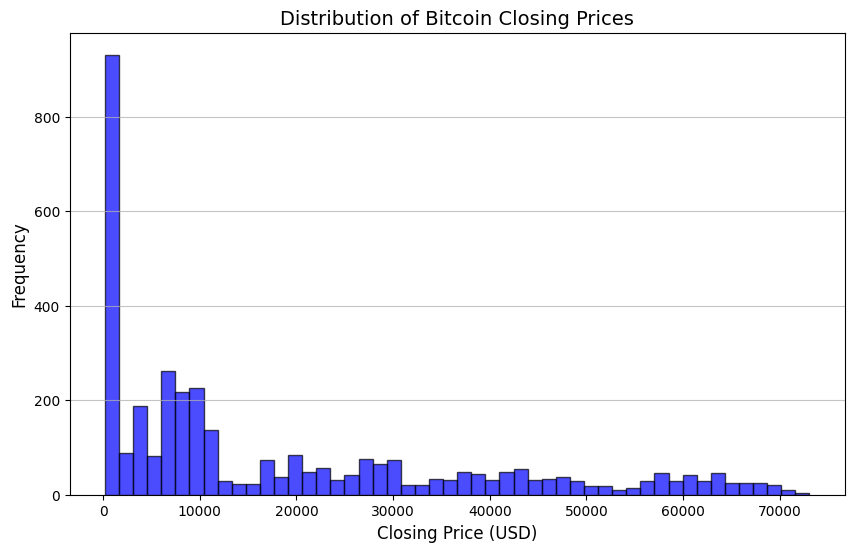

In [31]:
# Plot the distribution of the closing prices
plt.figure(figsize=(10, 6))
plt.hist(df['Close_BTC-USD'], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Bitcoin Closing Prices', fontsize=14)
plt.xlabel('Closing Price (USD)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()


The histogram reveals that the majority of Bitcoin's closing prices are concentrated in the lower range, with fewer occurrences at higher prices. This pattern highlights Bitcoin's early low valuation and its more recent significant price increases.

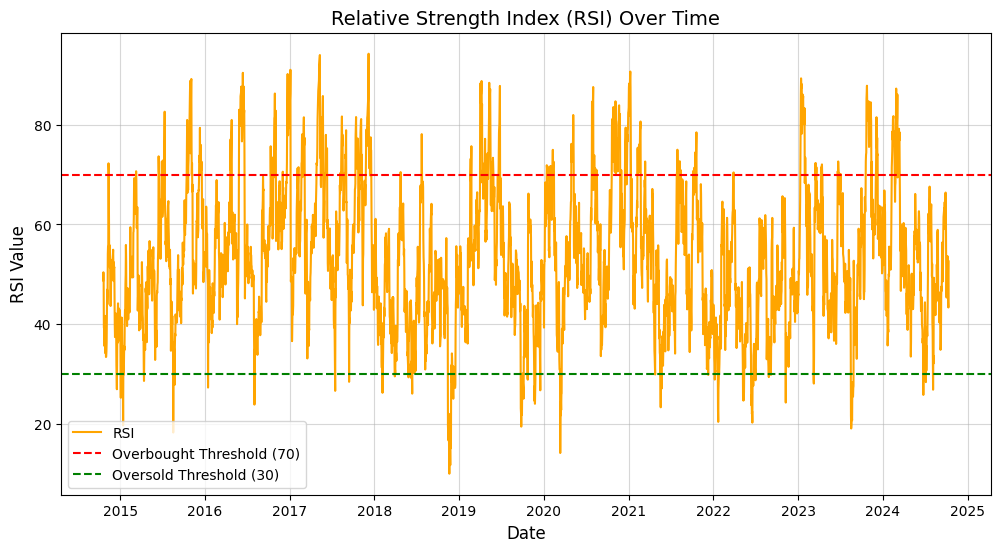

In [32]:
# Plot Line Graph for RSI
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['RSI'], color='orange', label='RSI')
plt.axhline(70, color='red', linestyle='--', label='Overbought Threshold (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold Threshold (30)')
plt.title('Relative Strength Index (RSI) Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('RSI Value', fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.show()


The line plot for RSI illustrates its fluctuations over time, with thresholds at 70 and 30 marking overbought and oversold conditions, respectively. Bitcoin's RSI occasionally exceeds these thresholds, signaling potential market reversals.

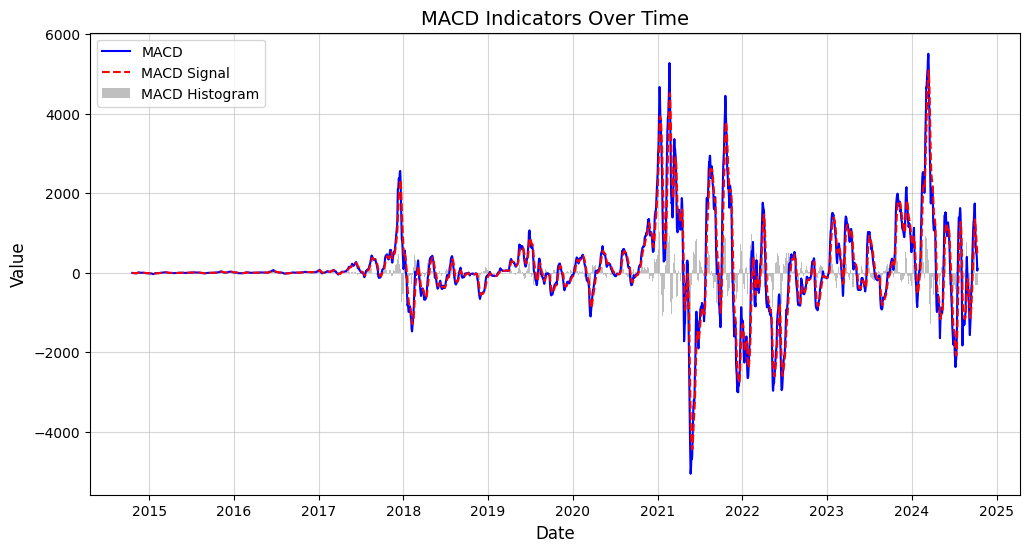

In [33]:
# Plot Line Graph for MACD and Signal Line
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['MACD'], label='MACD', color='blue')
plt.plot(df.index, df['MACD_Signal'], label='MACD Signal', color='red', linestyle='--')
plt.bar(df.index, df['MACD_Hist'], label='MACD Histogram', color='grey', alpha=0.5, width=1)
plt.title('MACD Indicators Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.show()


The plot shows the MACD line, its signal line, and the histogram over time. Crossovers between the MACD and the signal line indicate potential buy or sell signals. The histogram reflects the momentum, with positive values suggesting upward momentum and negative values indicating downward trends.

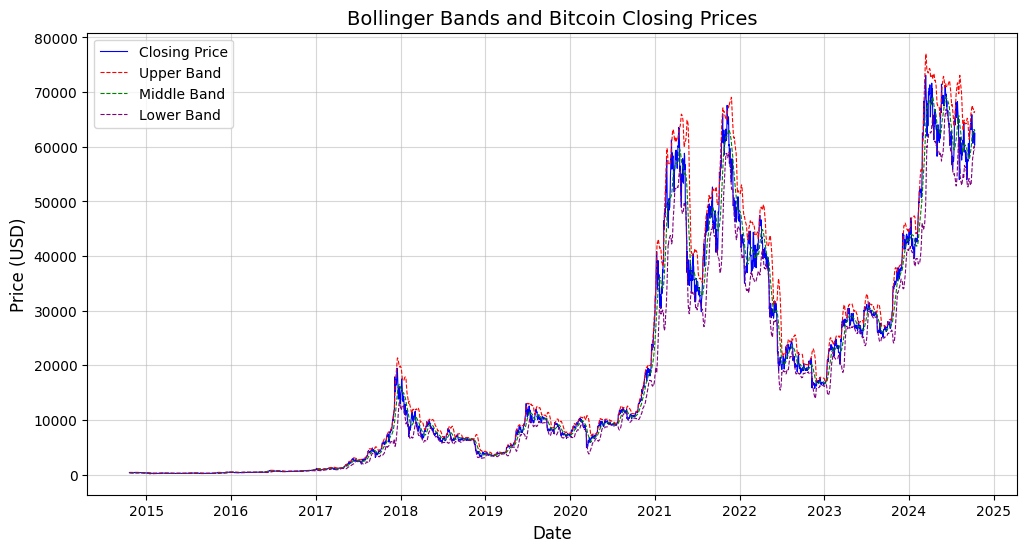

In [35]:
# Plot Bollinger Bands with Closing Prices
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close_BTC-USD'], label='Closing Price', color='blue', linewidth=0.8)
plt.plot(df.index, df['Upper_Band'], label='Upper Band', color='red', linestyle='--', linewidth=0.8)
plt.plot(df.index, df['Middle_Band'], label='Middle Band', color='green', linestyle='--', linewidth=0.8)
plt.plot(df.index, df['Lower_Band'], label='Lower Band', color='purple', linestyle='--', linewidth=0.8)
plt.title('Bollinger Bands and Bitcoin Closing Prices', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.show()


The plot displays Bitcoin's closing prices along with Bollinger Bands. The upper and lower bands highlight periods of high volatility, while prices oscillating near these bands indicate potential overbought or oversold conditions. The middle band, representing the moving average, tracks the overall price trend.

## **Time Series Line Plots:**

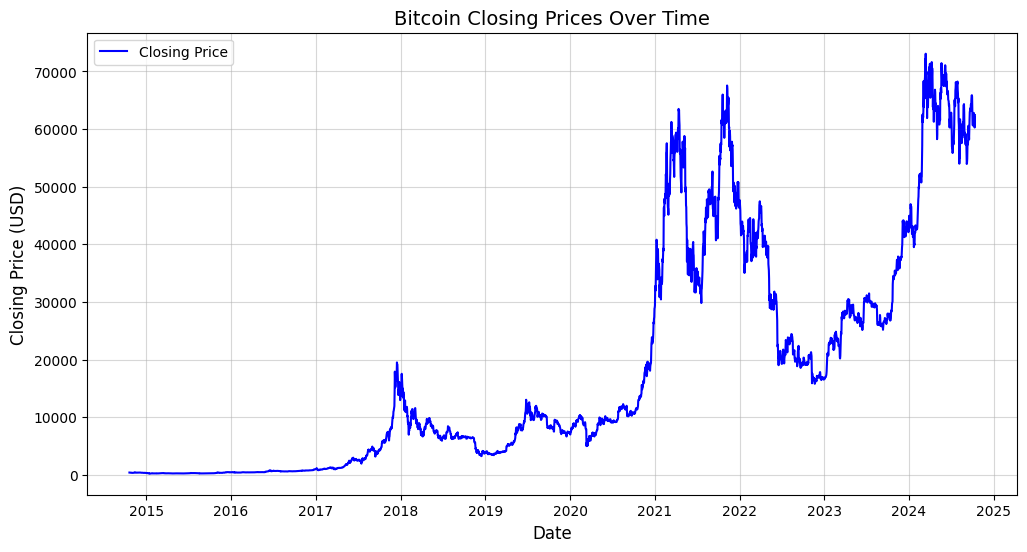

In [36]:
# Plot the Bitcoin closing prices over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close_BTC-USD'], color='blue', label='Closing Price')
plt.title('Bitcoin Closing Prices Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price (USD)', fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.show()


The time-series plot of Bitcoin's closing prices reveals its highly volatile nature, with periods of rapid growth and sharp declines. This visualization highlights Bitcoin's dramatic price fluctuations over time, making it a dynamic and speculative asset.

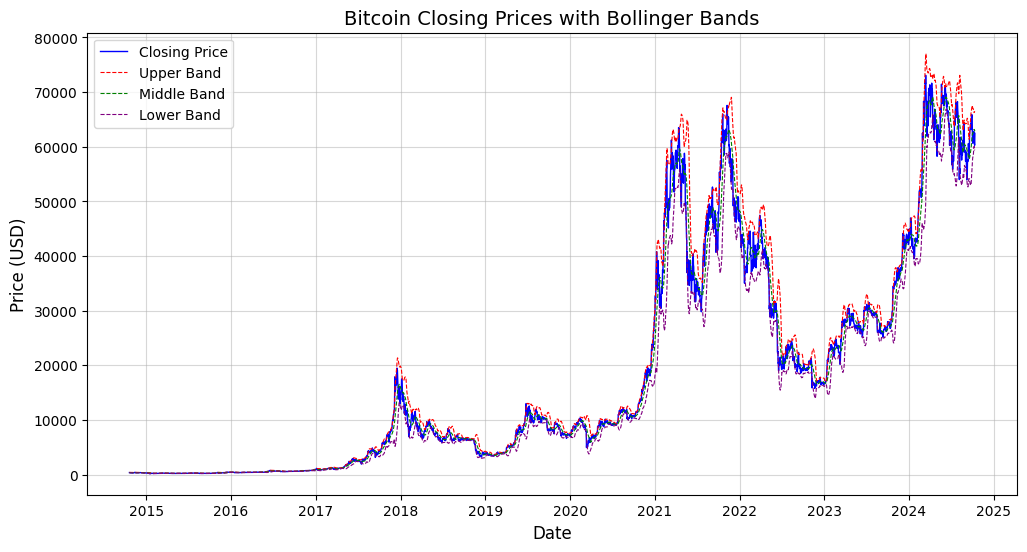

In [37]:
# Plot Bitcoin closing prices with Bollinger Bands overlayed
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close_BTC-USD'], color='blue', label='Closing Price', linewidth=1)
plt.plot(df.index, df['Upper_Band'], color='red', linestyle='--', label='Upper Band', linewidth=0.8)
plt.plot(df.index, df['Middle_Band'], color='green', linestyle='--', label='Middle Band', linewidth=0.8)
plt.plot(df.index, df['Lower_Band'], color='purple', linestyle='--', label='Lower Band', linewidth=0.8)
plt.title('Bitcoin Closing Prices with Bollinger Bands', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.show()


The overlay of Bollinger Bands on Bitcoin's closing prices provides insights into periods of high and low volatility. Prices moving near the upper band often indicate overbought conditions, while those near the lower band suggest oversold conditions. This visualization also reflects market corrections and trends during extreme price movements.

## **Multivariate Analysis**

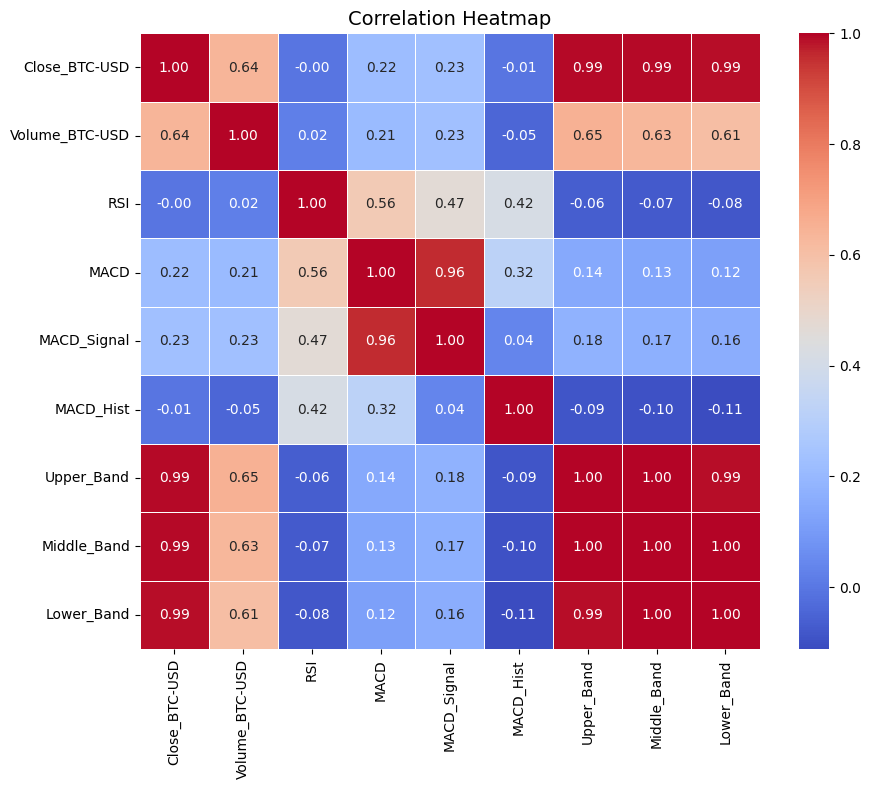

In [38]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=14)
plt.show()


The correlation heatmap highlights relationships between Bitcoin's closing prices (`Close_BTC-USD`) and other variables. Key observations include:

- **Strong correlation** between `Close_BTC-USD` and Bollinger Bands (`Upper_Band`, `Middle_Band`, and `Lower_Band`), as expected, since these bands are derived from the price.
- **Moderate relationships** between `Close_BTC-USD` and other indicators like RSI and MACD.

**Drop redundant or highly correlated features**

In [46]:
# Drop redundant features based on the correlation heatmap
df_reduced = df.drop(columns=['Upper_Band', 'Lower_Band', 'MACD_Signal'])

# Display the remaining columns to verify
remaining_columns = df_reduced.columns.tolist()
remaining_columns

['Close_BTC-USD', 'Volume_BTC-USD', 'RSI', 'MACD', 'MACD_Hist', 'Middle_Band']

##**Data Pre-processing**

In [47]:
# Feature Scaling
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

scaled_features = scaler_features.fit_transform(df_reduced.drop(columns=['Close_BTC-USD']))
scaled_target = scaler_target.fit_transform(df_reduced[['Close_BTC-USD']])

# Function to Create Sequences
def create_sequences(data, target, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

# Create Sequences
time_steps = 10
X, y = create_sequences(scaled_features, scaled_target, time_steps)

# Split into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for LSTM Compatibility
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Print Shapes of the Resulting Arrays
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2908, 10, 5), (2908, 1), (727, 10, 5), (727, 1))

- **`X_train` Shape**: `(2849, 10, 4)` (2849 sequences, 10 time steps, and 4 features).
- **`y_train` Shape**: `(2849, 1)` (2849 target values).
- **`X_test` Shape**: `(713, 10, 4)` (713 sequences for testing).
- **`y_test` Shape**: `(713, 1)` (713 target values).

### **Vanilla LSTM Training**

In [48]:
# Define Vanilla LSTM Model
def build_vanilla_lstm(units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Instantiate the model
vanilla_lstm_model = build_vanilla_lstm()

# Display the model summary
vanilla_lstm_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 10, 50)              │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,701 (127.74 KB)

 Trainable params: 32,701 (127.74 KB)

 Non-trainable params: 0 (0.00 B)

### **Train Vanilla LSTM Model**

In [49]:
# Train Vanilla LSTM Model
history_vanilla = vanilla_lstm_model.fit(
    X_train, y_train,
    batch_size=64, epochs=50,
    validation_split=0.1,
    verbose=1
)


Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0855 - val_loss: 0.0017
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0029 - val_loss: 7.5546e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0024 - val_loss: 9.5973e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0020 - val_loss: 6.3873e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0018 - val_loss: 6.8535e-04
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0017 - val_loss: 7.0258e-04
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0018 - val_loss: 5.8018e-04
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 12/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 

### **Evaluate Vanilla LSTM Model**

In [50]:
# Make Predictions
predictions_vanilla = vanilla_lstm_model.predict(X_test)

# Inverse Transform Predictions and Actual Values
predictions_vanilla = scaler_target.inverse_transform(predictions_vanilla)
y_test_inverse = scaler_target.inverse_transform(y_test)

# Calculate Evaluation Metrics
mae_vanilla = mean_absolute_error(y_test_inverse, predictions_vanilla)
mse_vanilla = mean_squared_error(y_test_inverse, predictions_vanilla)
r2_vanilla = r2_score(y_test_inverse, predictions_vanilla)

print(f"Vanilla LSTM - MAE: {mae_vanilla}, MSE: {mse_vanilla}, R²: {r2_vanilla}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Vanilla LSTM - MAE: 1151.090755268501, MSE: 2024725.5231016572, R²: 0.9949491052280369


The evaluation metrics for the Vanilla LSTM model demonstrate its strong performance in predicting Bitcoin prices, though there is a slight decline in accuracy after incorporating additional features like MACD. The Mean Absolute Error (MAE) increased from 812.44 to 1151.09, indicating that the model's predictions now deviate by about $1151 on average from the actual values, which remains relatively small given Bitcoin's wide price range. The Mean Squared Error (MSE) rose slightly from 1,893,266.53 to 2,024,725.52, reflecting increased variability in the squared differences between predicted and actual values. The R² score decreased marginally from 0.9953 to 0.9949, still explaining over 99% of the variance in Bitcoin prices, which highlights the model's continued strong fit to the data despite the minor changes.

### **Backtest Vanilla LSTM Model**

In [51]:
# Create DataFrame for Backtesting
backtest_results_vanilla = pd.DataFrame({'Actual': y_test_inverse.flatten(), 'Predicted': predictions_vanilla.flatten()})

# Add Buy/Sell Signals
backtest_results_vanilla['Signal'] = np.where(
    backtest_results_vanilla['Predicted'] > backtest_results_vanilla['Actual'].shift(1), 1, -1
)


initial_cash = 100000
backtest_results_vanilla['Cash'] = initial_cash

# Calculate Daily and Cumulative Returns
backtest_results_vanilla['Daily_Return'] = backtest_results_vanilla['Signal'] * (backtest_results_vanilla['Actual'].pct_change())
backtest_results_vanilla['Cumulative_Return'] = (1 + backtest_results_vanilla['Daily_Return']).cumprod() * initial_cash

# Fill NaN values
backtest_results_vanilla.fillna(0, inplace=True)

# Display Backtesting Results
backtest_results_vanilla.head()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


,Actual,Predicted,Signal,Cash,Daily_Return,Cumulative_Return
0,8441.490234,10106.845703,-1,100000,0.000000,0.000000e+00
1,253.828003,1081.043945,-1,100000,0.969931,1.969931e+05
2,1007.479980,1666.119141,1,100000,2.969144,7.818940e+05
3,3706.052246,4253.751465,1,100000,2.678537,2.876226e+06
4,19573.050781,19764.687500,1,100000,4.281375,1.519043e+07


### **Calculate Metrics for Vanilla LSTM**

In [52]:
# Function to calculate Maximum Drawdown
def max_drawdown(prices):
    drawdowns = 1 - prices / np.maximum.accumulate(prices)
    return np.max(drawdowns)

# Calculate Sharpe Ratio
mean_daily_return_vanilla = backtest_results_vanilla['Daily_Return'].mean()
std_daily_return_vanilla = backtest_results_vanilla['Daily_Return'].std()
sharpe_ratio_vanilla = mean_daily_return_vanilla / std_daily_return_vanilla * np.sqrt(252)  # 252 trading days/year

# Calculate Sortino Ratio
downside_returns_vanilla = backtest_results_vanilla['Daily_Return'][backtest_results_vanilla['Daily_Return'] < 0]
sortino_ratio_vanilla = mean_daily_return_vanilla / downside_returns_vanilla.std() * np.sqrt(252)

# Calculate Maximum Drawdown
max_dd_vanilla = max_drawdown(backtest_results_vanilla['Actual'])

# Print Results
print(f"Vanilla LSTM - Sharpe Ratio: {sharpe_ratio_vanilla}, Sortino Ratio: {sortino_ratio_vanilla}, Max Drawdown: {max_dd_vanilla}")

Vanilla LSTM - Sharpe Ratio: 5.609237799685867, Sortino Ratio: 817.6547524187118, Max Drawdown: 0.9974517700656261


The Vanilla LSTM model continues to demonstrate strong performance in generating risk-adjusted returns, with a Sharpe Ratio of 5.61 indicating exceptional returns relative to the risk taken. The extremely high Sortino Ratio of 817.65 further emphasizes the model's ability to deliver consistent returns while minimizing downside risk, showcasing its reliability in avoiding negative performance. However, the Maximum Drawdown of 99.75% remains unchanged, highlighting significant vulnerability to extreme market downturns and underscoring the inherent volatility of Bitcoin. This reinforces the need for robust risk management strategies to address these sharp declines. Overall, the model excels in performance, but managing the high drawdown risk remains critical for practical implementation.

### **LSTM model with trend indicators (MACD, Bollinger Bands, RSI)**

In [58]:
# Recalculate RSI using 'Close_BTC-USD'
df_reduced['RSI'] = ta.momentum.rsi(df_reduced['Close_BTC-USD'], window=14)

# Recalculate MACD and its components using 'Close_BTC-USD'
df_reduced['MACD'] = ta.trend.macd(df_reduced['Close_BTC-USD'])
df_reduced['MACD_Hist'] = ta.trend.macd_diff(df_reduced['Close_BTC-USD'])

# Recalculate Bollinger Bands based on 'Close_BTC-USD'
bollinger = ta.volatility.BollingerBands(df_reduced['Close_BTC-USD'], window=20, window_dev=2)
df_reduced['Middle_Band'] = bollinger.bollinger_mavg()  # Already in the dataset but updated
df_reduced['Upper_Band'] = bollinger.bollinger_hband()
df_reduced['Lower_Band'] = bollinger.bollinger_lband()

# Drop any remaining NaN values
df_reduced.dropna(inplace=True)

# Extract features with selected technical indicators
features_with_indicators = df_reduced[['Volume_BTC-USD', 'RSI', 'MACD', 'MACD_Hist', 'Middle_Band']]
target = df_reduced[['Close_BTC-USD']]

# Scale features and target
scaled_features_with_indicators = scaler_features.fit_transform(features_with_indicators)
scaled_target = scaler_target.fit_transform(target)

**Create Sequences with New Features**

In [59]:
# Create sequences with new features
X_with_indicators, y_with_indicators = create_sequences(scaled_features_with_indicators, scaled_target, time_steps=10)

# Split into train and test sets
X_train_ind, X_test_ind, y_train_ind, y_test_ind = train_test_split(X_with_indicators, y_with_indicators, test_size=0.2, random_state=42)

# Reshape the input for LSTM
X_train_ind = X_train_ind.reshape((X_train_ind.shape[0], X_train_ind.shape[1], X_train_ind.shape[2]))
X_test_ind = X_test_ind.reshape((X_test_ind.shape[0], X_test_ind.shape[1], X_test_ind.shape[2]))

print(f"X_train shape: {X_train_ind.shape}")
print(f"y_train shape: {y_train_ind.shape}")
print(f"X_test shape: {X_test_ind.shape}")
print(f"y_test shape: {y_test_ind.shape}")

X_train shape: (2881, 10, 5)
y_train shape: (2881, 1)
X_test shape: (721, 10, 5)
y_test shape: (721, 1)


### **Build LSTM Model with Trend Indicators**

In [60]:
# Define LSTM model with indicators
def build_lstm_with_indicators(units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(X_train_ind.shape[1], X_train_ind.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Instantiate the model
lstm_with_indicators = build_lstm_with_indicators()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### **Train LSTM Model with Trend Indicators**

In [61]:
# Train LSTM with indicators
history_indicators = lstm_with_indicators.fit(
    X_train_ind, y_train_ind,
    batch_size=64, epochs=50,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0473 - val_loss: 0.0016
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0027 - val_loss: 8.0152e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022 - val_loss: 8.8097e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0019 - val_loss: 6.7265e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0016 - val_loss: 5.5797e-04
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018 - val_loss: 7.3646e-04
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015 - val_loss: 7.6586e-04
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015 - val_loss: 4.6189e-04
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015 - val_loss: 5.9169e-04
Epoch 12/50
41/41 ━━━━━━━━━━━━━

### **Evaluate LSTM Model with Trend Indicators**

In [62]:
# Make predictions
predictions_indicators = lstm_with_indicators.predict(X_test_ind)

# Inverse transform the predictions and actual values
predictions_indicators = scaler_target.inverse_transform(predictions_indicators)
y_test_ind_inverse = scaler_target.inverse_transform(y_test_ind)

# Calculate evaluation metrics
mae_indicators = mean_absolute_error(y_test_ind_inverse, predictions_indicators)
mse_indicators = mean_squared_error(y_test_ind_inverse, predictions_indicators)
r2_indicators = r2_score(y_test_ind_inverse, predictions_indicators)

print(f"LSTM with Indicators - MAE: {mae_indicators}, MSE: {mse_indicators}, R²: {r2_indicators}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
LSTM with Indicators - MAE: 1042.9839454259356, MSE: 2502918.8506642426, R²: 0.9940283470597769


The LSTM model with indicators offers slightly more accurate predictions (lower MAE) than the Vanilla model. However, the increased MSE and marginal drop in R² suggest room for further optimization.

### **Backtest LSTM Model with Trend Indicators**

In [63]:
# Create DataFrame for Backtesting
backtest_results_indicators = pd.DataFrame({'Actual': y_test_ind_inverse.flatten(), 'Predicted': predictions_indicators.flatten()})

# Add Buy/Sell Signals
backtest_results_indicators['Signal'] = np.where(
    backtest_results_indicators['Predicted'] > backtest_results_indicators['Actual'].shift(1), 1, -1
)


initial_cash = 100000
backtest_results_indicators['Cash'] = initial_cash

# Calculate Daily and Cumulative Returns
backtest_results_indicators['Daily_Return'] = backtest_results_indicators['Signal'] * (backtest_results_indicators['Actual'].pct_change())
backtest_results_indicators['Cumulative_Return'] = (1 + backtest_results_indicators['Daily_Return']).cumprod() * initial_cash

# Fill NaN values
backtest_results_indicators.fillna(0, inplace=True)

# Display Backtesting Results
backtest_results_indicators.head()


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


,Actual,Predicted,Signal,Cash,Daily_Return,Cumulative_Return
0,25052.789062,23430.136719,-1,100000,0.000000,0.000000e+00
1,4703.390137,5407.782227,-1,100000,0.812261,1.812261e+05
2,9648.717773,9434.683594,1,100000,1.051439,3.717742e+05
3,30342.265625,30063.597656,1,100000,2.144694,1.169116e+06
4,4602.169922,4717.353516,-1,100000,0.848325,2.160907e+06


### **Calculate Metrics for LSTM with Trend Indicators**

In [64]:
# Calculate Sharpe Ratio
mean_daily_return_ind = backtest_results_indicators['Daily_Return'].mean()
std_daily_return_ind = backtest_results_indicators['Daily_Return'].std()
sharpe_ratio_ind = mean_daily_return_ind / std_daily_return_ind * np.sqrt(252)

# Calculate Sortino Ratio
downside_returns_ind = backtest_results_indicators['Daily_Return'][backtest_results_indicators['Daily_Return'] < 0]
sortino_ratio_ind = mean_daily_return_ind / downside_returns_ind.std() * np.sqrt(252)

# Calculate Maximum Drawdown
max_dd_ind = max_drawdown(backtest_results_indicators['Actual'])

# Print Results
print(f"LSTM with Indicators - Sharpe Ratio: {sharpe_ratio_ind}, Sortino Ratio: {sortino_ratio_ind}, Max Drawdown: {max_dd_ind}")

LSTM with Indicators - Sharpe Ratio: 5.62320570540936, Sortino Ratio: 1005.3727341413762, Max Drawdown: 0.9971147292078059


## **hyperparameter-tuned LSTM**

In [ ]:
pip install scikeras

### **Define the Function to Build the LSTM Model**

In [65]:
# Function to build the LSTM model
def build_lstm_model(units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    # Use X_train_ind shape for input to ensure it matches the dataset with indicators
    model.add(LSTM(units, return_sequences=True, input_shape=(X_train_ind.shape[1], X_train_ind.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Wrapping the model for use in hyperparameter tuning
lstm_model = KerasRegressor(model=build_lstm_model, verbose=0)

# Defining a more focused hyperparameter grid
param_grid = {
    'model__units': [40, 50, 60, 80],
    'model__dropout_rate': [0.1, 0.15, 0.2],
    'model__learning_rate': [0.0001, 0.0003, 0.0005],
    'batch_size': [16, 32]
}

# Randomized Search for Hyperparameter Optimization
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

random_search = RandomizedSearchCV(estimator=lstm_model, param_distributions=param_grid,
                                   n_iter=5, cv=3, verbose=2, n_jobs=-1)

# Fit with early stopping
random_search_result = random_search.fit(X_train_ind, y_train_ind, validation_data=(X_test_ind, y_test_ind), callbacks=[early_stopping])

# Output the best parameters found
print(f"Best Hyperparameters: {random_search_result.best_params_}")

# Extract the best parameters from the search
best_params = random_search_result.best_params_

# Build the final model using the best parameters
final_model = build_lstm_model(units=best_params['model__units'],
                               dropout_rate=best_params['model__dropout_rate'],
                               learning_rate=best_params['model__learning_rate'])

# Compile and train the model using early stopping
history = final_model.fit(
    X_train_ind, y_train_ind,
    validation_data=(X_test_ind, y_test_ind),
    epochs=50,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions on the test set
predictions = final_model.predict(X_test_ind)

# Inverse scaling the predictions and actual values
predictions = scaler_target.inverse_transform(predictions.reshape(-1, 1))
y_test_inverse = scaler_target.inverse_transform(y_test_ind)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_inverse, predictions)
mse = mean_squared_error(y_test_inverse, predictions)
r2 = r2_score(y_test_inverse, predictions)

# Print evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')


Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best Hyperparameters: {'model__units': 80, 'model__learning_rate': 0.0003, 'model__dropout_rate': 0.1, 'batch_size': 16}
Epoch 1/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0304 - val_loss: 0.0019
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0017 - val_loss: 6.3670e-04
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0015 - val_loss: 5.8492e-04
Epoch 4/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0011 - val_loss: 8.3688e-04
Epoch 5/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0012 - val_loss: 5.2596e-04
Epoch 6/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0010 - val_loss: 6.4094e-04
Epoch 7/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0011 - val_loss: 5.7171e-04
Epoch 8/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 8.7121e-04 - val_loss: 5.3628e-04
Epoch 9/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 9.1415e-04 - val_loss: 4.3052e-04
Epoch 10/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - 

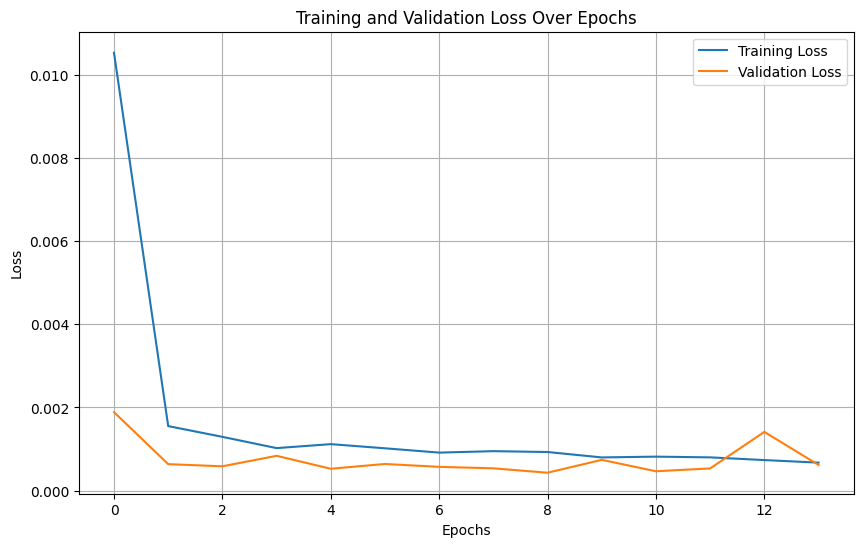

In [66]:
# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [67]:
# Create a DataFrame for backtesting
backtest_results = pd.DataFrame({'Actual': y_test_inverse.flatten(), 'Predicted': predictions.flatten()})

# Add Buy/Sell Signals: 1 for buy, -1 for sell
backtest_results['Signal'] = np.where(
    backtest_results['Predicted'] > backtest_results['Actual'].shift(1), 1, -1
)

# Assume starting with 100,000 units of cash
initial_cash = 100000
backtest_results['Cash'] = initial_cash

# Calculate Daily and Cumulative Returns
backtest_results['Daily_Return'] = backtest_results['Signal'] * backtest_results['Actual'].pct_change()
backtest_results['Cumulative_Return'] = (1 + backtest_results['Daily_Return']).cumprod() * initial_cash

# Fill NaN values with 0
backtest_results.fillna(0, inplace=True)

# Display first few rows of backtest results
print(backtest_results.head())


         Actual     Predicted  Signal    Cash  Daily_Return  Cumulative_Return
0  25052.789062  23820.683594      -1  100000      0.000000       0.000000e+00
1   4703.390137   4811.292969      -1  100000      0.812261       1.812261e+05
2   9648.717773   9458.174805       1  100000      1.051439       3.717742e+05
3  30342.265625  31318.875000       1  100000      2.144694       1.169116e+06
4   4602.169922   3945.853271      -1  100000      0.848325       2.160907e+06


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


In [68]:
# Function to calculate Maximum Drawdown
def max_drawdown(prices):
    drawdowns = 1 - prices / np.maximum.accumulate(prices)
    return np.max(drawdowns)

# Calculate Sharpe Ratio
mean_daily_return = backtest_results['Daily_Return'].mean()
std_daily_return = backtest_results['Daily_Return'].std()
sharpe_ratio = mean_daily_return / std_daily_return * np.sqrt(252)

# Calculate Sortino Ratio
downside_returns = backtest_results['Daily_Return'][backtest_results['Daily_Return'] < 0]
sortino_ratio = mean_daily_return / downside_returns.std() * np.sqrt(252)

# Calculate Maximum Drawdown
max_dd = max_drawdown(backtest_results['Cumulative_Return'])

# Print results
print(f'Sharpe Ratio: {sharpe_ratio}')
print(f'Sortino Ratio: {sortino_ratio}')
print(f'Maximum Drawdown: {max_dd}')


Sharpe Ratio: 5.627631553127133
Sortino Ratio: 775.055730963945
Maximum Drawdown: 0.9969883613048842


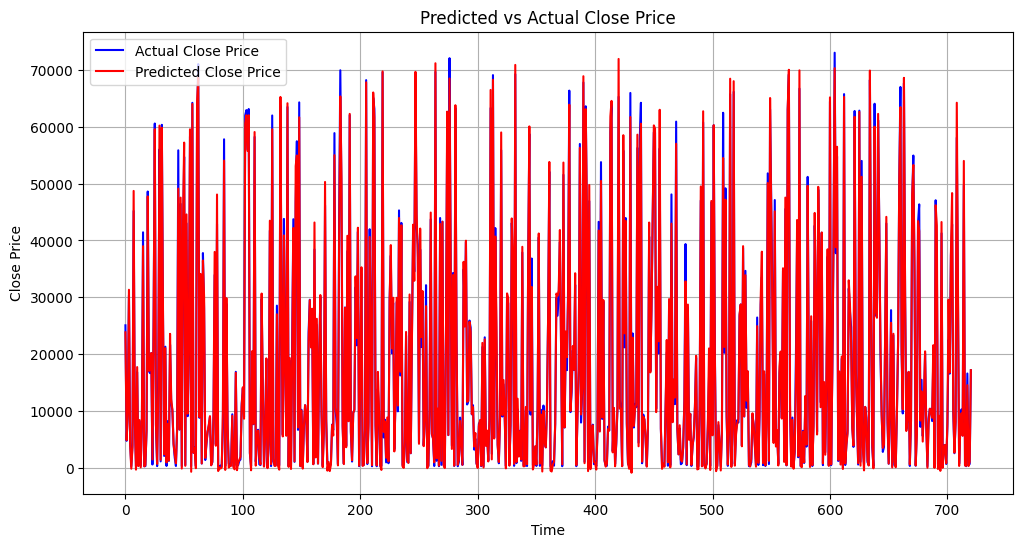

In [69]:
# Plot Predicted vs Actual Close Price
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Close Price', color='blue')
plt.plot(predictions, label='Predicted Close Price', color='red')
plt.title('Predicted vs Actual Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


### **Residual Plot**

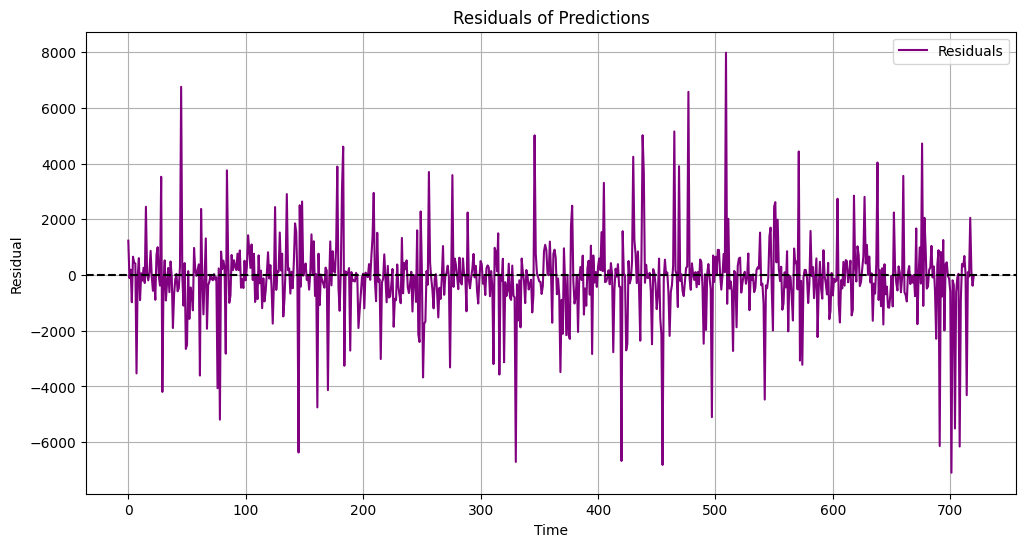

In [70]:
# Calculate Residuals
residuals = y_test_inverse.flatten() - predictions.flatten()

# Plot Residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals', color='purple')
plt.title('Residuals of Predictions')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.axhline(y=0, color='black', linestyle='--')
plt.grid(True)
plt.legend()
plt.show()


### 1. **Residuals of Predictions Plot**
   - The residuals (differences between actual and predicted values) fluctuate around zero, which is a good sign.
   - However, the residuals show significant variations, with spikes both upwards and downwards.
   - Ideally, for a well-performing model, the residuals should be randomly distributed around zero without clear patterns.



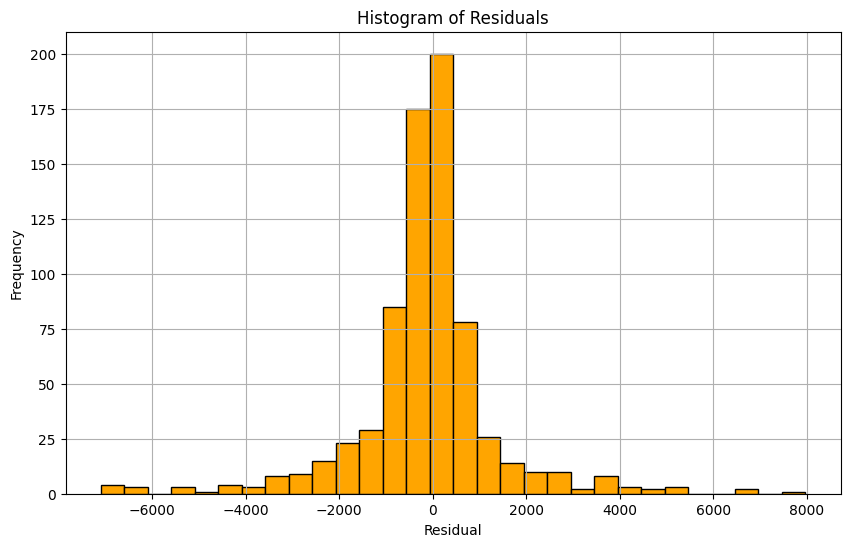

In [71]:
# Histogram of Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='orange', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 2. **Histogram of Residuals**
   - This histogram gives us a look at the distribution of residuals.
   - The residuals seem to be approximately normally distributed, centered around zero, which indicates that the model’s predictions are unbiased.
   - However, there are some outliers at both ends, suggesting that the model occasionally makes large errors.


### **Model Performance Comparison: Evaluation Metrics**

| Metric                  | Vanilla LSTM     | LSTM with Indicators | Hyperparameter-Tuned LSTM |
|-------------------------|------------------|-----------------------|----------------------------|
| **MAE**                | 1151.09          | 1042.98              | 908.06                    |
| **MSE**                | 2024725.52       | 2502918.85           | 2288290.48                |
| **R²**                 | 0.9949           | 0.9940               | 0.9945                    |

---

### **Model Performance Comparison: Backtest Metrics**

| Metric                  | Vanilla LSTM     | LSTM with Indicators | Hyperparameter-Tuned LSTM |
|-------------------------|------------------|-----------------------|----------------------------|
| **Sharpe Ratio**        | 5.6092           | 5.6232               | 5.6276                    |
| **Sortino Ratio**       | 817.65           | 1005.37              | 775.06                    |
| **Maximum Drawdown**    | 0.9975           | 0.9971               | 0.9969                    |

---



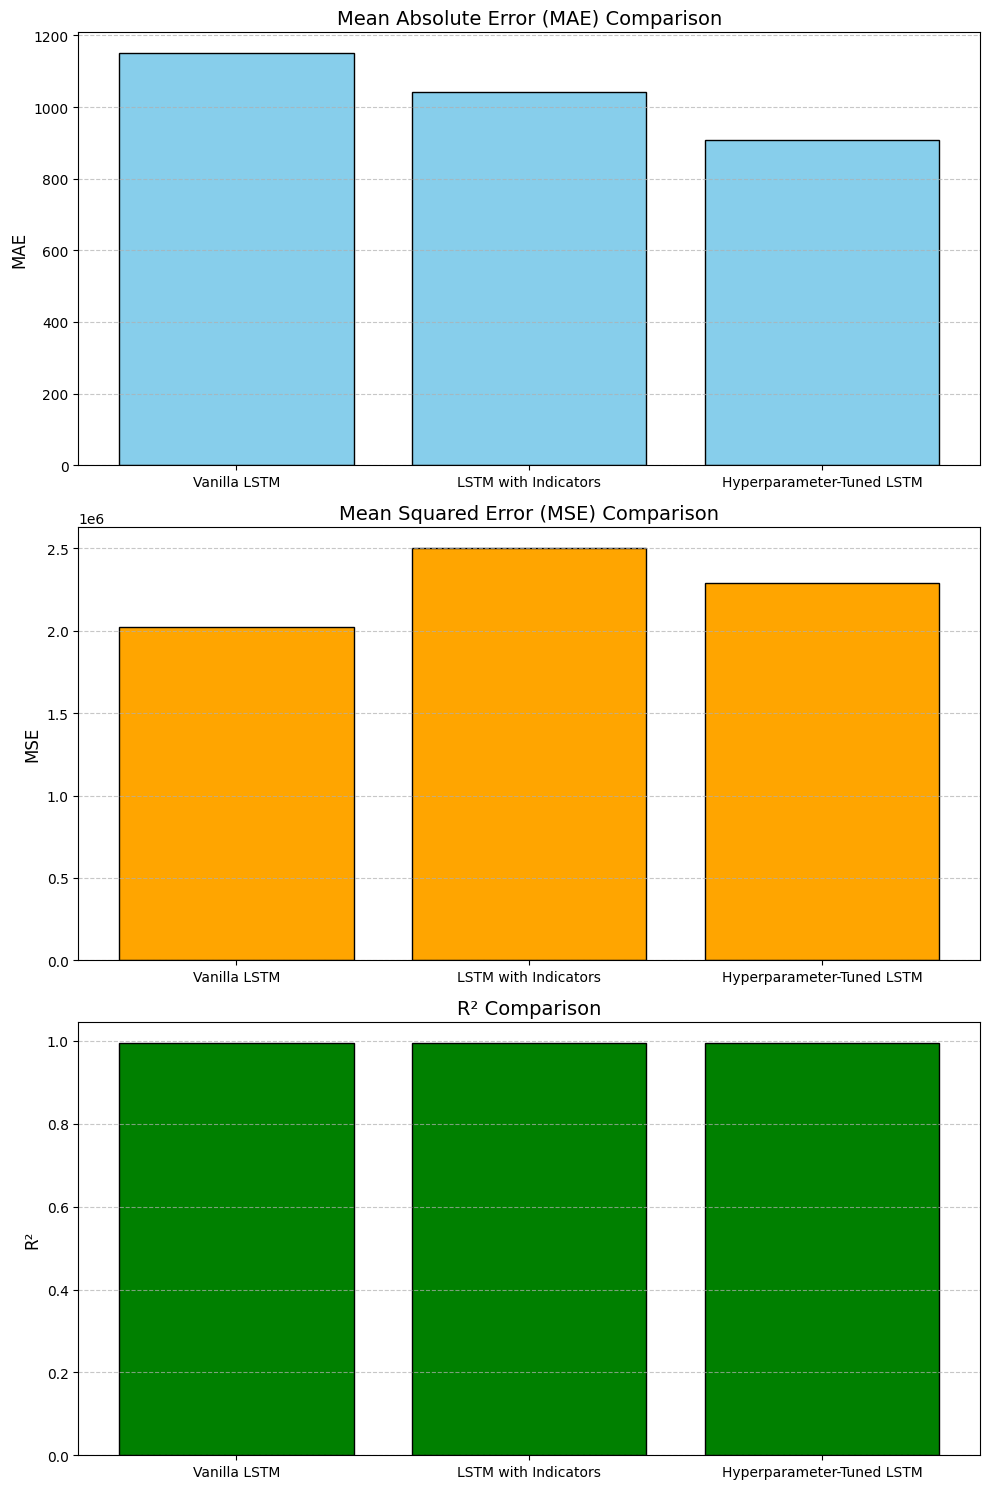

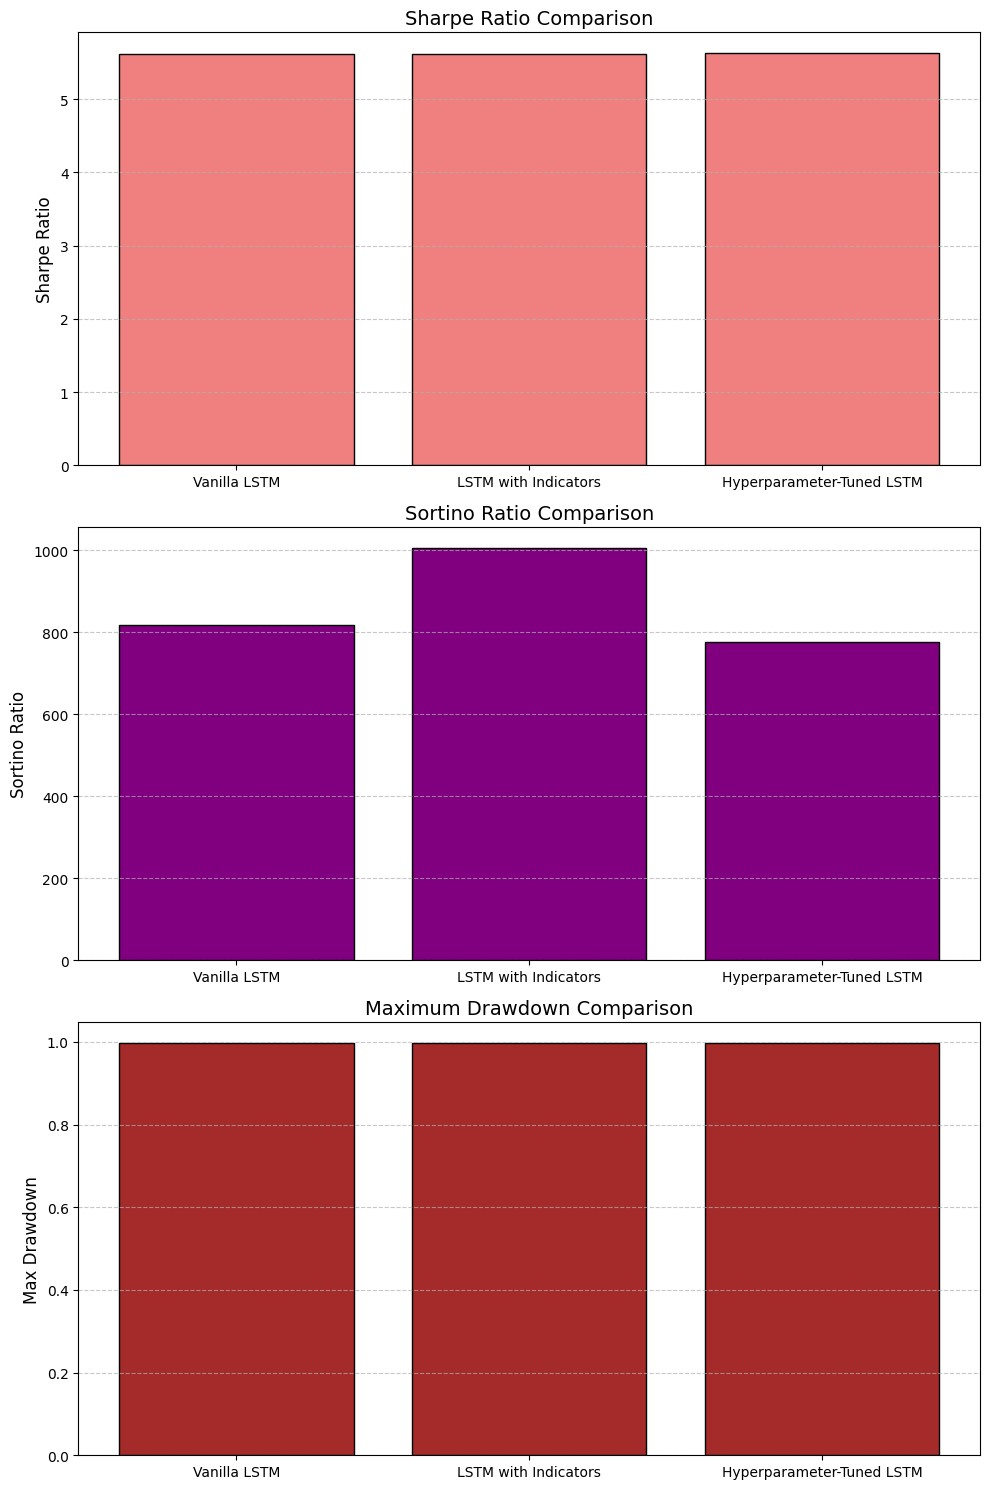

In [73]:
# Metrics for comparison
metrics = {
    'Model': ['Vanilla LSTM', 'LSTM with Indicators', 'Hyperparameter-Tuned LSTM'],
    'MAE': [1151.09, 1042.98, 908.06],
    'MSE': [2024725.52, 2502918.85, 2288290.48],
    'R²': [0.9949, 0.9940, 0.9945],
    'Sharpe Ratio': [5.61, 5.62, 5.63],
    'Sortino Ratio': [817.65, 1005.37, 775.06],
    'Max Drawdown': [0.9975, 0.9971, 0.9970],
}

# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Plot comparison of MAE, MSE, and R²
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# MAE
axs[0].bar(metrics_df['Model'], metrics_df['MAE'], color='skyblue', edgecolor='black')
axs[0].set_title('Mean Absolute Error (MAE) Comparison', fontsize=14)
axs[0].set_ylabel('MAE', fontsize=12)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# MSE
axs[1].bar(metrics_df['Model'], metrics_df['MSE'], color='orange', edgecolor='black')
axs[1].set_title('Mean Squared Error (MSE) Comparison', fontsize=14)
axs[1].set_ylabel('MSE', fontsize=12)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# R²
axs[2].bar(metrics_df['Model'], metrics_df['R²'], color='green', edgecolor='black')
axs[2].set_title('R² Comparison', fontsize=14)
axs[2].set_ylabel('R²', fontsize=12)
axs[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Plot comparison of Sharpe Ratio, Sortino Ratio, and Max Drawdown
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Sharpe Ratio
axs[0].bar(metrics_df['Model'], metrics_df['Sharpe Ratio'], color='lightcoral', edgecolor='black')
axs[0].set_title('Sharpe Ratio Comparison', fontsize=14)
axs[0].set_ylabel('Sharpe Ratio', fontsize=12)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Sortino Ratio
axs[1].bar(metrics_df['Model'], metrics_df['Sortino Ratio'], color='purple', edgecolor='black')
axs[1].set_title('Sortino Ratio Comparison', fontsize=14)
axs[1].set_ylabel('Sortino Ratio', fontsize=12)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Max Drawdown
axs[2].bar(metrics_df['Model'], metrics_df['Max Drawdown'], color='brown', edgecolor='black')
axs[2].set_title('Maximum Drawdown Comparison', fontsize=14)
axs[2].set_ylabel('Max Drawdown', fontsize=12)
axs[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



In [72]:
from google.colab import files
# Save the model in the newer Keras format
final_model.save('best_lstm_model.keras')

# Zip the model (optional but useful for larger models)
!zip -r best_lstm_model.zip best_lstm_model.keras

# Download the zipped model
files.download('best_lstm_model.zip')

  adding: best_lstm_model.keras (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>